**Executed:** Sat Apr  8 15:26:21 2017

**Duration:** 15 seconds.

> See issue: https://github.com/tritemio/FRETBursts/issues/47

# Loading FRETBursts

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.6.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

In [3]:
filename = './data/test_DM1_smFRET_40MHz.h5'
filename

'./data/test_DM1_smFRET_40MHz.h5'

In [4]:
filename = './data/test_DM1_smFRET.h5'
filename

'./data/test_DM1_smFRET.h5'

In [5]:
filename = './data/ncodina/test_DM1_smFRET_40MHz.h5'
filename

'./data/ncodina/test_DM1_smFRET_40MHz.h5'

# Selecting a data file

Alternatively you can use an open-file dialog in order to select a data file:

In [6]:
# filename = OpenFileDialog()
# filename

In [7]:
import os
if os.path.isfile(filename):
    print("Perfect, I found the file!")
else:
    print("Sorry, I can't find the file:\n%s" % filename)

Perfect, I found the file!


# Load data


In [8]:
d = loader.photon_hdf5(filename)

In [9]:
d.time_max

44.656760200000001

# Initial data exploration

## TCSPC data

In [10]:
d.nanotimes_

array([ 25,   0,   0, ..., 597, 407, 356], dtype=uint16)

In [11]:
d.nanotimes_params

[{'tcspc_num_bins': 3125, 'tcspc_range': 2.5e-08, 'tcspc_unit': 8e-12}]

In [12]:
1.6e-11 * 65536

1.048576e-06

Are you sure 65536 is the right number of bins?

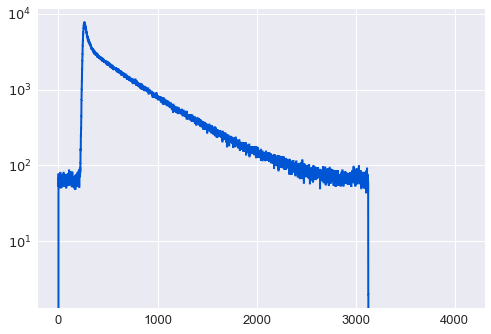

In [13]:
plt.hist(d.nanotimes_, bins=np.arange(4096), histtype='step', lw=2)
plt.yscale('log')

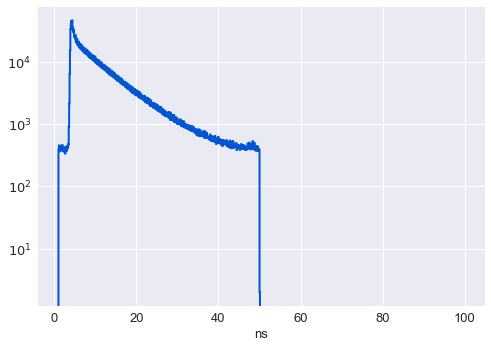

In [14]:
plt.hist(d.nanotimes_*1.6e-2, bins=np.arange(1, 100, 0.1), histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('ns')

## Timetrace of timestamps (macro-times)

The next 3 cells allows to scroll the timetrace in a GUI in an external window (the cells are disabled).
You need to switch to the QT backend and then switch back to inline to have plots in the notebook.

(-300, 300)

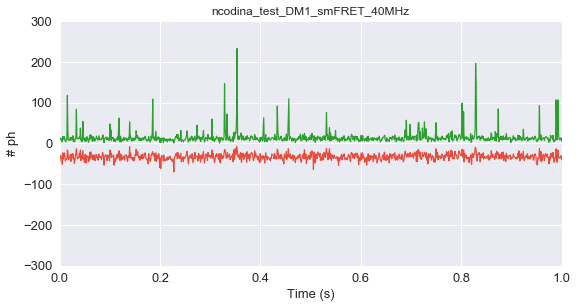

In [15]:
dplot(d, timetrace, tmax=10)
plt.ylim(-300, 300)

(-100, 100)

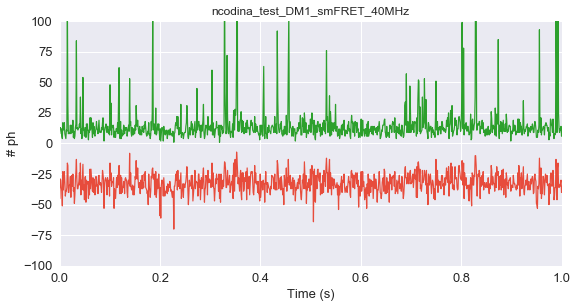

In [16]:
dplot(d, timetrace, tmax=10)
plt.ylim(-100, 100)

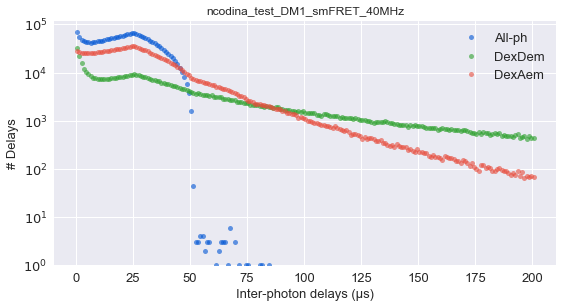

In [17]:
dplot(d, hist_interphoton, xunit='us', binwidth=1e-6, tmax=200e-6)

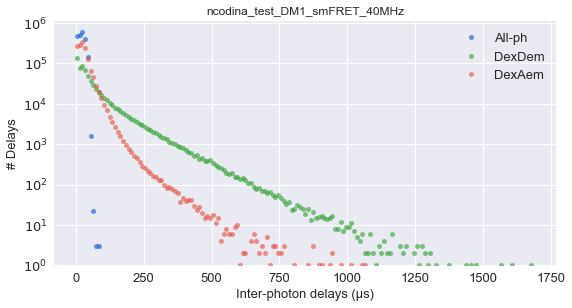

In [18]:
dplot(d, hist_bg, binwidth=10e-6, xunit='us', period=None, show_fit=False)

Pretty high background: by eye ~50kcps for Donor and 10kcps for Acceptor. 

The the background fit with default parameters may fail. Better to start with a manual
threshold:

In [19]:
#d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=0.5)

In [20]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us=(20, 300, 300))

 - Calculating BG rates ... 

[DONE]


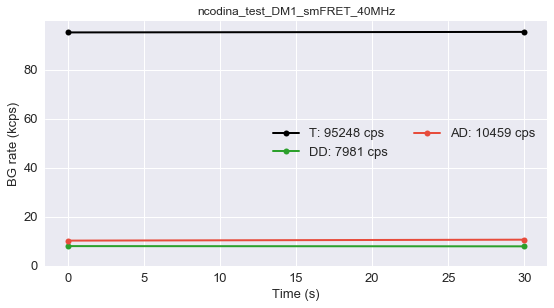

In [21]:
dplot(d, timetrace_bg)

In [22]:
d.bg[Ph_sel(Dex='Aem')], d.bg[Ph_sel(Dex='Dem')]

([array([ 10270.04678175,  10649.2336795 ])],
 [array([ 8030.79383605,  7932.2977389 ])])

It doesn't look right, the DD and T background is too high (0.8 and 1.7Mcps!). Let's see the
histogram of time-lags between timestamps:

/Users/anto/miniconda3/lib/python3.5/site-packages/fretbursts/burst_plot.py:1513: RuntimeWarning: invalid value encountered in true_divide
  y_fit *= counts_integral / y_fit[i_tau_th:].sum()


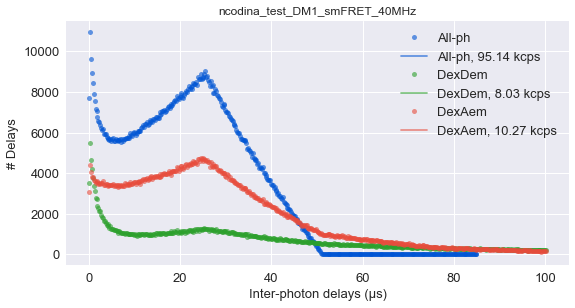

In [23]:
dplot(d, hist_bg, show_fit=True, binwidth=0.2e-6, xunit='us', tmax=100e-6, yscale='linear')

In [24]:
ph_d = d.get_ph_times(ph_sel=Ph_sel(Dex='Dem'))
ph_a = d.get_ph_times(ph_sel=Ph_sel(Dex='Aem'))

In [25]:
mask_d = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))
mask_a = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))

In [26]:
ph = d.ph_times_m_

In [27]:
dph = np.diff(d.ph_times_m_).astype(float) * d.clk_p * 1e6

In [28]:
mask = np.hstack([dph > 40, False])
mask

array([False, False, False, ..., False, False, False], dtype=bool)

In [29]:
mask.shape

(2117562,)

In [30]:
mask_d.shape

(2117562,)

In [31]:
ph.shape

(2117562,)

In [32]:
mask_dph_alt = np.diff(mask_d.view('int8')) != 0

In [33]:
d.clk_p, ph_d.shape

(2.5e-08, (668797,))

In [34]:
dph = np.diff(d.ph_times_m_).astype(float) * d.clk_p * 1e6  # us
dph_d = np.diff(ph_d).astype(float) * d.clk_p * 1e6  # us
dph_a = np.diff(ph_a).astype(float) * d.clk_p * 1e6  # us

In [35]:
dph_d.mean(), dph_d.max(), dph_d.min()

(66.771372436438014, 1672.75, 0.024999999999999998)

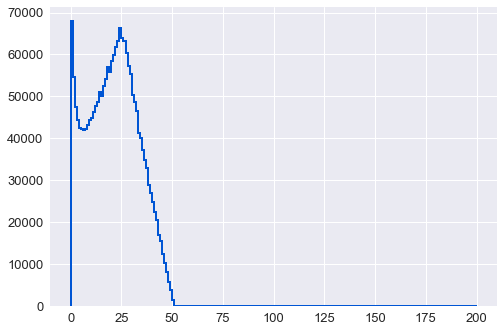

In [36]:
plt.hist(dph, bins=np.arange(0, 201, 1), histtype='step', lw=2);

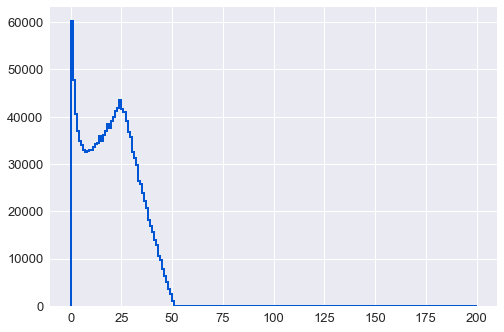

In [37]:
plt.hist(dph[~mask_dph_alt], bins=np.arange(0, 201, 1), histtype='step', lw=2);

Same result with the manual plot. This looks a hardware or decoding error. 
The max delay between timestamps is 50us!
Let's zoom a bit:

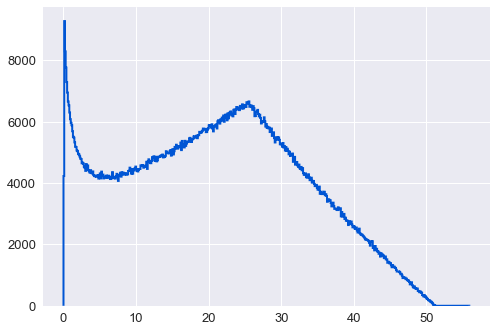

In [38]:
plt.hist(dph, bins=np.arange(0, 56, 0.1) + 10e-9, histtype='step', lw=2);

In [39]:
%config InlineBackend.figure_format = 'retina'

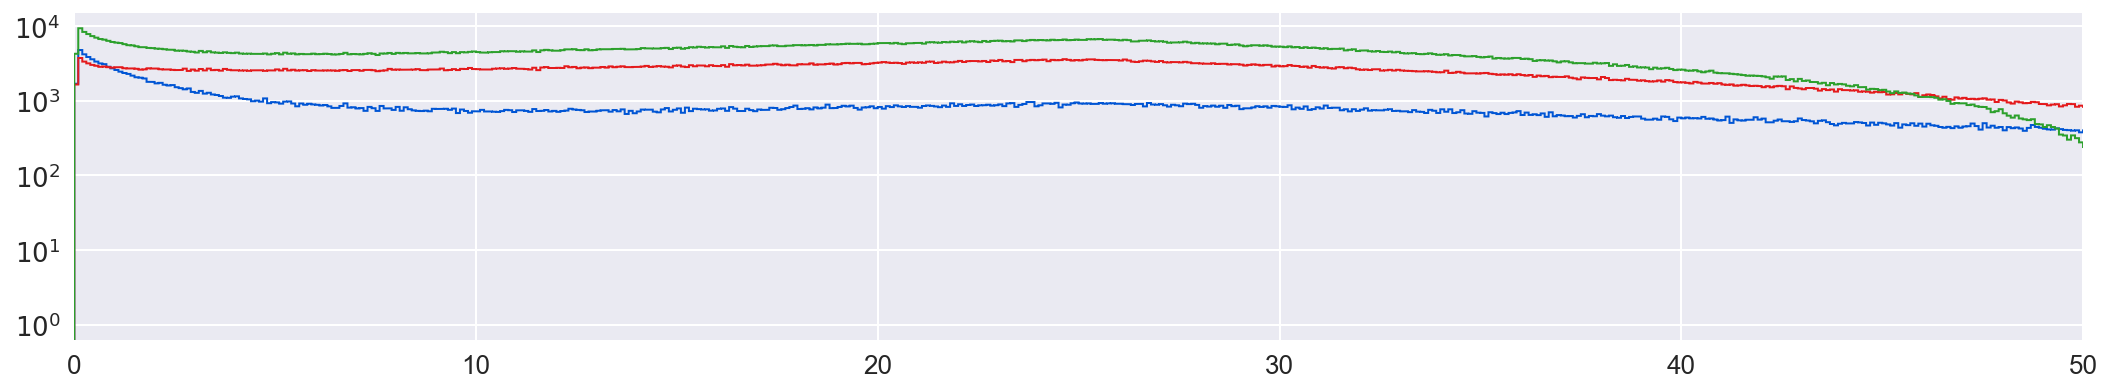

In [40]:
fig, ax = plt.subplots(figsize=(18, 3))
kw = dict(bins=np.arange(0, 100, 0.1) + 10e-9, histtype='step', lw=1)
ax.hist(dph_d, **kw)
ax.hist(dph_a, **kw)
ax.hist(dph, **kw)
#plt.ylim(10, 200000)
plt.xlim(0, 50)
plt.yscale('log')

In [41]:
ph_d.shape, ph_a.shape

((668797,), (1448765,))

Very strange pattern!

Let's look at the raw timestamps:

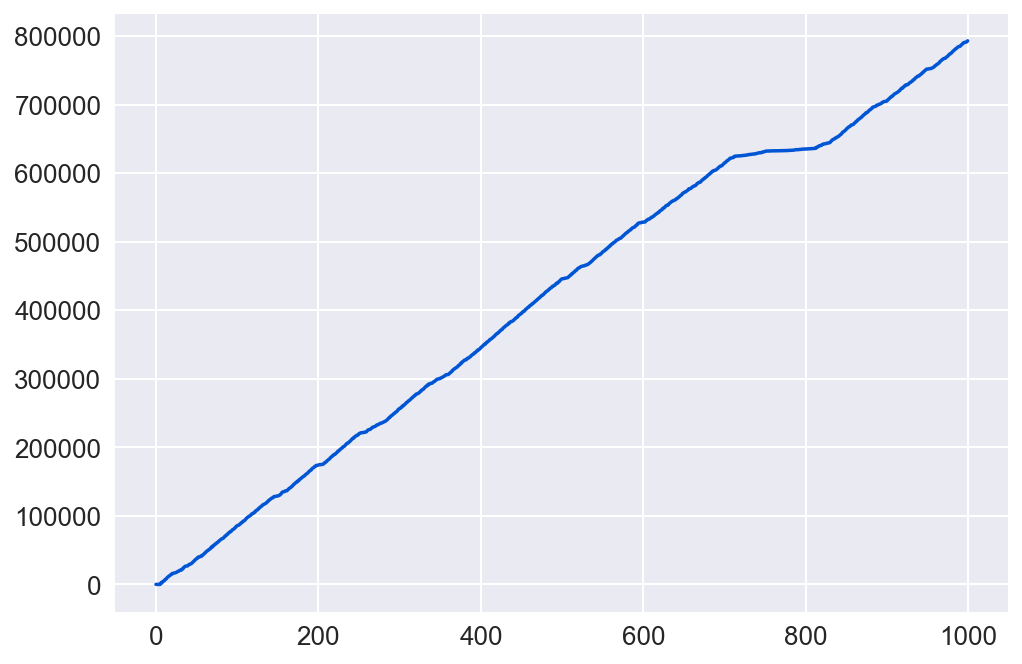

In [42]:
plt.plot(d.ph_times_m_[:1000])

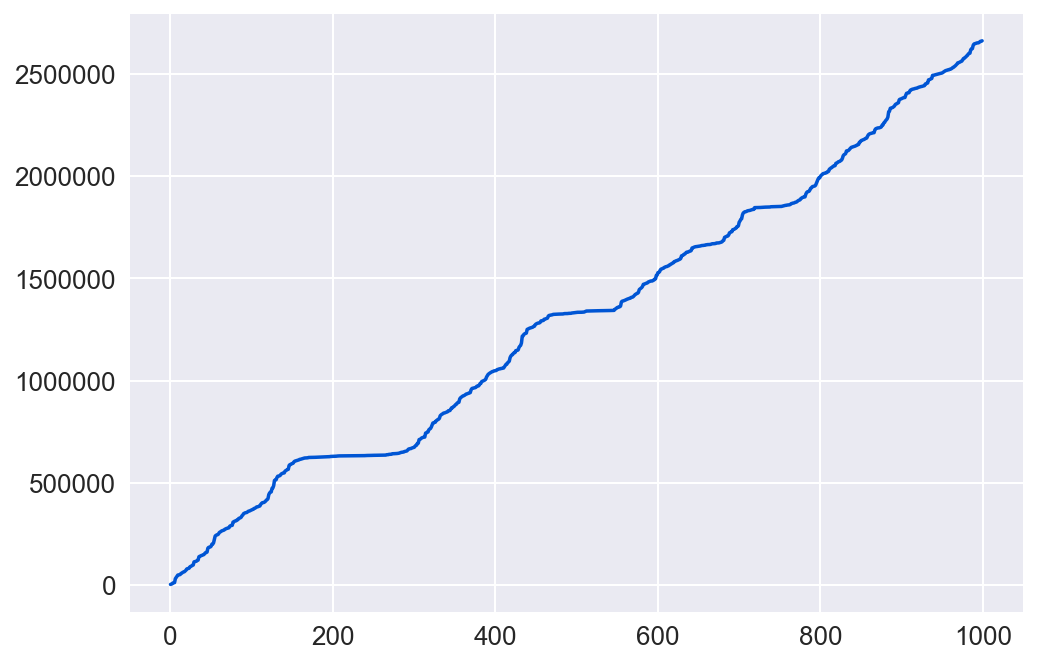

In [43]:
plt.plot(ph_d[:1000])

In [44]:
(ph_d > 0).all()

True

Looks fine here.

Let's look at the acceptor channels now:

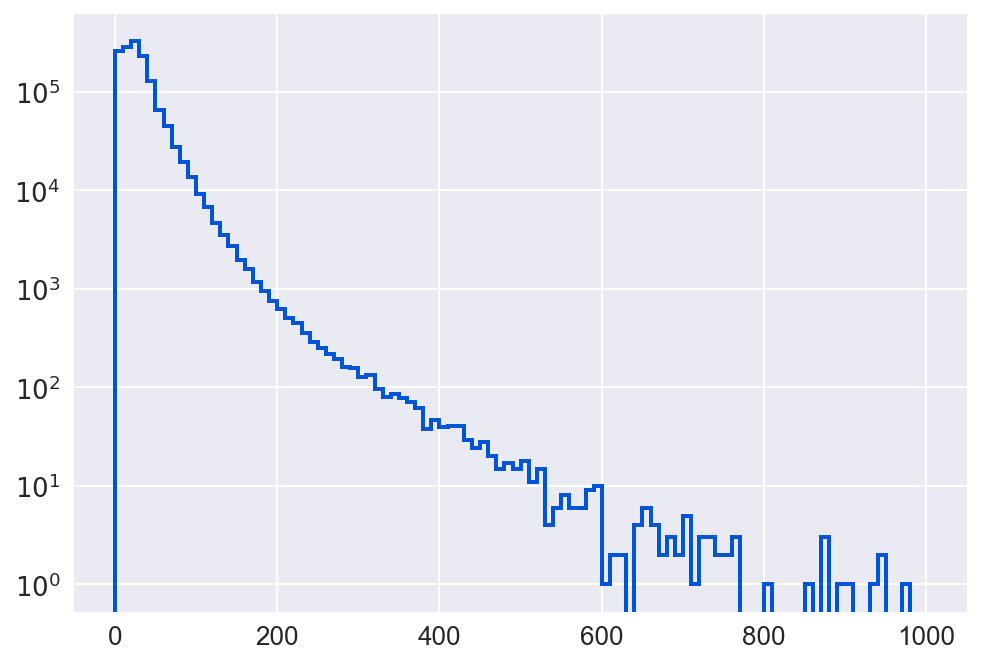

In [45]:
plt.hist(dph_a, bins=np.arange(0, 1001, 10), histtype='step', lw=2);
plt.yscale('log')

OK. Zooming:

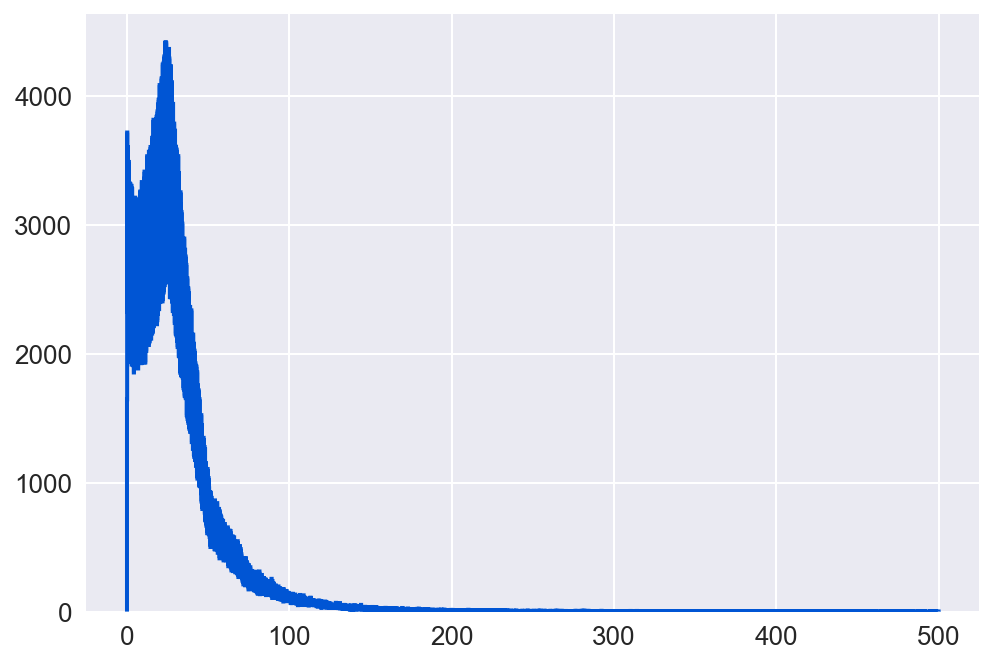

In [46]:
plt.hist(dph_a, bins=np.arange(0, 500, 0.1), histtype='step', lw=2);

(0, 20)

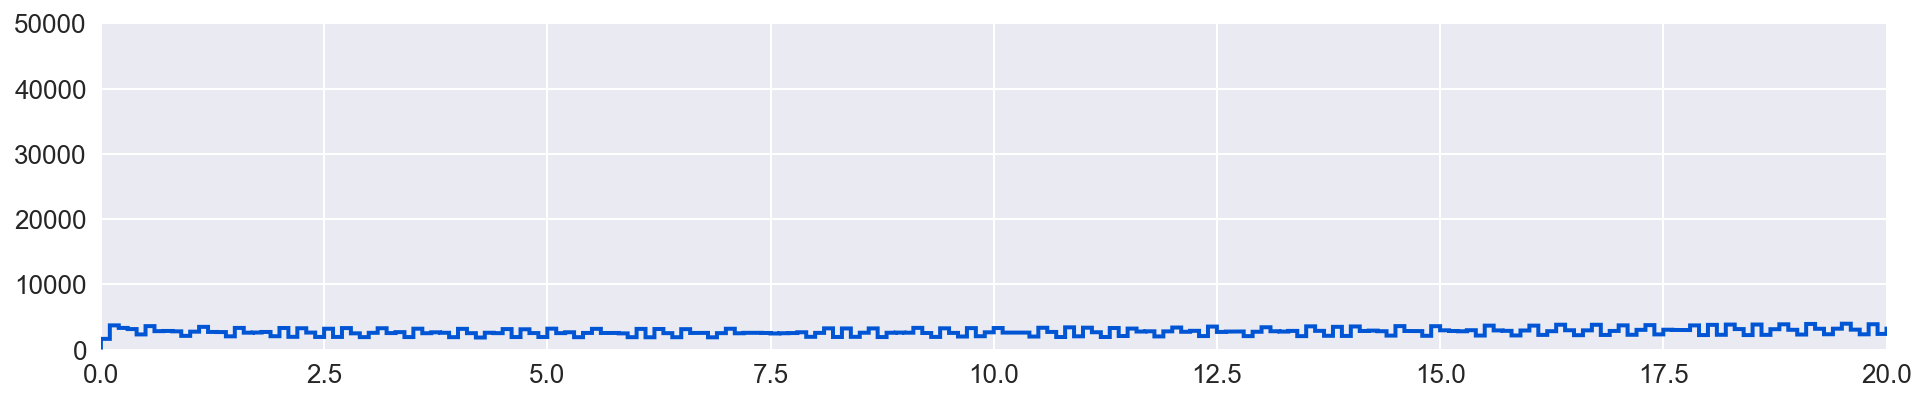

In [47]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.hist(dph_a, bins=np.arange(0, 56, 0.1), histtype='step', lw=2);
plt.ylim(0, 50000)
plt.xlim(0, 20)

Still this pattern doesn't look OK.

 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


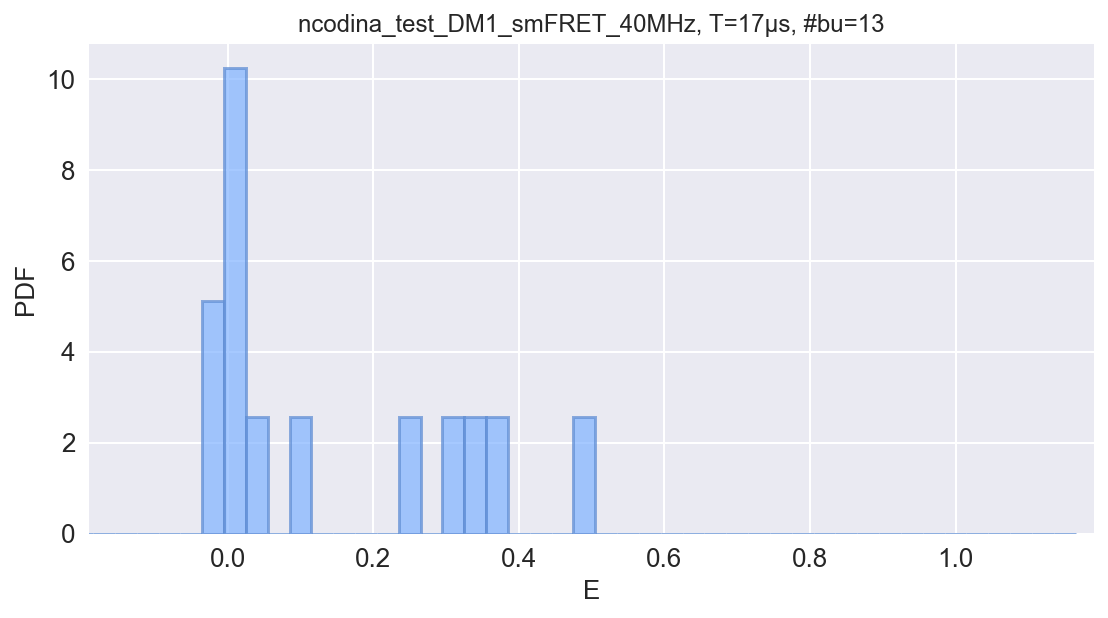

In [48]:

d.burst_search()
ds = d.select_bursts(select_bursts.size, th1=50)
dplot(ds, hist_fret)
ds2 = ds.select_bursts(select_bursts.E, E1=0.6)
mask_d = ds2.ph_in_bursts_mask_ich(ph_sel=Ph_sel(Dex='Dem'))
mask_a = ds2.ph_in_bursts_mask_ich(ph_sel=Ph_sel(Dex='Aem'))

In [49]:
d.calc_ph_num()

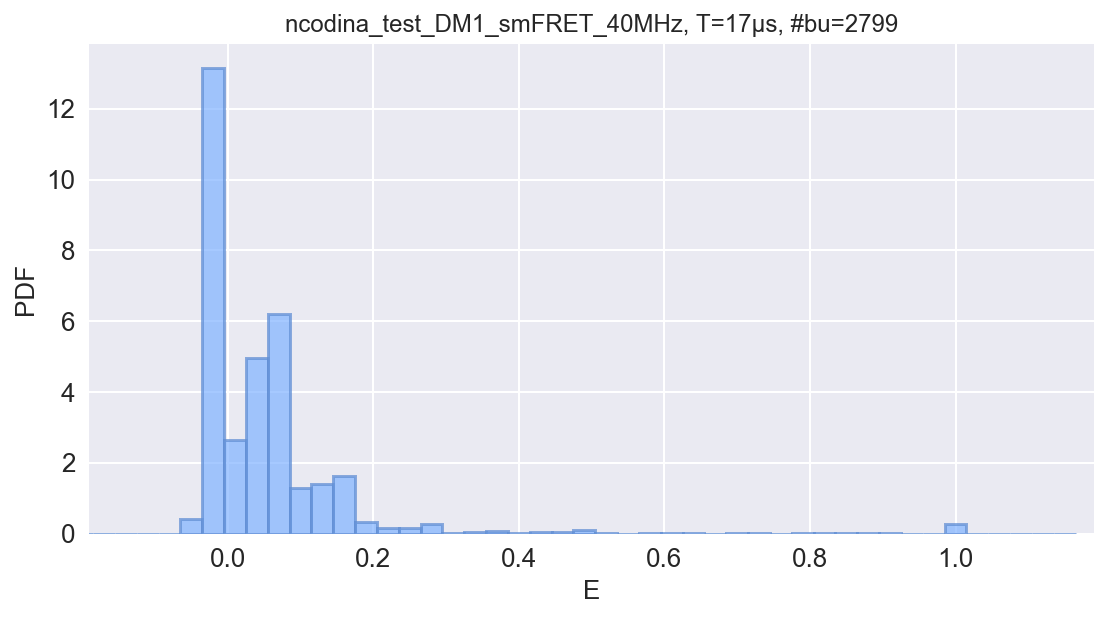

In [50]:
dplot(d, hist_fret)

In [51]:
ds = d.select_bursts(select_bursts.size, th1=50)

   - Applying background correction.


   - Applying leakage correction.


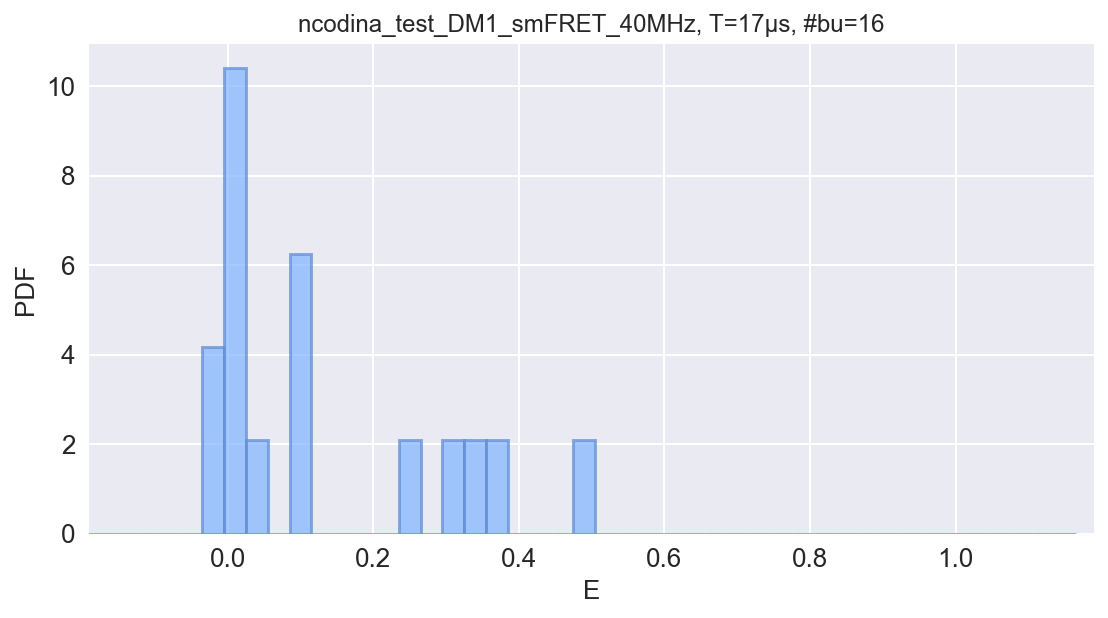

In [52]:
dplot(ds, hist_fret)

In [53]:
ds2 = ds.select_bursts(select_bursts.E, E1=0.6)

In [54]:
mask_d = ds2.ph_in_bursts_mask_ich(ph_sel=Ph_sel(Dex='Dem'))
mask_a = ds2.ph_in_bursts_mask_ich(ph_sel=Ph_sel(Dex='Aem'))

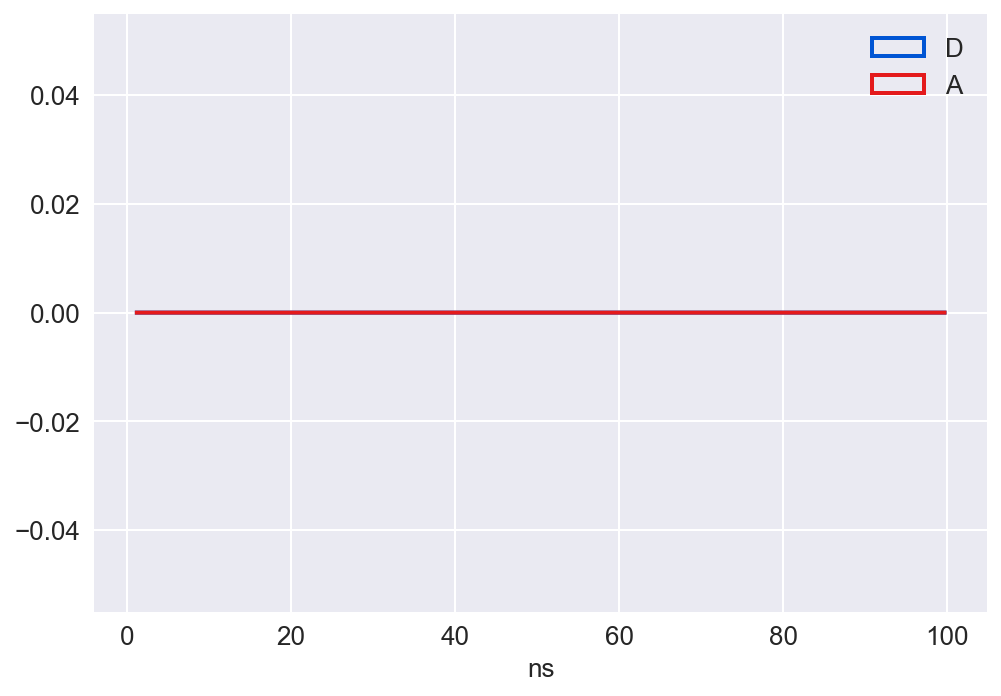

In [55]:
kw = dict(bins=np.arange(1, 100, 0.1), histtype='step', lw=2)
plt.hist(d.nanotimes_[mask_d]*1.6e-2, label='D', **kw)
plt.hist(d.nanotimes_[mask_a]*1.6e-2, label='A', **kw)
#plt.yscale('log')
plt.xlabel('ns')
plt.legend();